## Libs

In [1]:
# Массивы
import numpy as np

# Отрисовка графиков
import matplotlib.pyplot as plt

# Загрузка из google облака
import gdown

# Преобразование категориальных данных в one hot encoding
from tensorflow.keras.utils import to_categorical

# Работа с папками и файлами
import os

# Утилиты работы со временем
import time

# Работа со случайными числами
import random

# Математические функции
import math

# Сохранение и загрузка структур данных Python
import pickle

# Параметризация аудио
import librosa

# Оптимизаторы для обучения моделей
from tensorflow.keras.optimizers import Adam, RMSprop

# Конструирование и загрузка моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model, load_model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.layers import MaxPooling1D, AveragePooling1D, SpatialDropout1D

# Разбиение на обучающую и проверочную выборку
from sklearn.model_selection import train_test_split

# Кодирование категориальных меток, нормирование числовых данных
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Отключение предупреждений
import warnings
# warnings.filterwarnings('ignore')
import IPython.display as ipd             # Проигрывание аудио в colab
import librosa.display                    # Визуализация аудио

import os
%matplotlib inline

C:\Users\user\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Dataset_1 processing 1.

## girerparams and base showing functions

In [34]:
FOLDER = 'audio_genres'
FILE_DIR = FOLDER
download_path = 'https://storage.yandexcloud.net/aiueducation/Content/base/l12/genres.zip'
CLASS_LIST = os.listdir(FOLDER)
CLASS_LIST = [x for x in CLASS_LIST if '.' not in x]
CLASS_LIST.sort()                         # Сортировка списка классов для фиксации порядка меток
CLASS_COUNT = len(CLASS_LIST)
CLASS_FILES = 100                         # Общее количество файлов в каждом классе
FILE_INDEX_TRAIN_SPLIT = 90               # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.1                    # Доля проверочной выборки в основном наборе
DURATION_SEC = 30                         # Анализируемая длительность аудиосигнала по умолчанию
FEATURE_LENGTH_SEC = 15                    # Длительность обрабатываемого файла (sec)
FEATURE_HOP_LENGTH_SEC = 2                    # Шаг обработки аудио-файла (sec)
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
# HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков

In [35]:
CLASS_LIST

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

## Service functions

In [16]:
def show_data_folder(folder):
    print(f'Folder contains: {os.listdir(folder)})')
    print(f'One-level folder contains: {os.listdir(os.path.join(folder, os.listdir(folder)[0]))}')

def download_path(download_path, output=None):
    gdown.download(download_path, output, quiet=True)

# Функция оценки точности модели на заданной выборке
def eval_model(model,  # обученная модель нейронной сети
               x,      # входные данные
               y_true  # выходные данные (верные ответы)
               ):
    loss, acc = model.evaluate(x, y_true)
    print(f'Ошибка: {loss}, точность: {acc}')

    # Построение матрицы ошибок
    y_pred = model.predict(x)
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок нормализованная')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()

def load_audio(audio_path,       # путь к файлу с аудио
               show_text=True,   # показывать ли текстовую сводку по аудио
               show_player=True  # выводить ли проигрыватель в ячейку
               ):
    # Загрузка аудиофайла, на выходе:
    # x  - массив данных временного ряда аудио
    # sr - частота дискретизации временного ряда
    x, sr = librosa.load(audio_path)

    if show_text:
        # Вывод текстовых данных о сигнале
        print(f'Типы данных x и sr: {type(x)}, {type(sr)}')
        print(f'Форма данных x: {x.shape}, sr = {sr}')
        print('Продолжительность сигнала:', round(x.shape[0]/sr), 'с.\n')

    if show_player:
        # Вывод проигрывателя в ячейку colab
        ipd.display(ipd.Audio(audio_path))

    # Возврат загруженных данных для дальнейшего использования
    return x, sr

def extract_data(folder_path = FOLDER,
                 duration_sec=DURATION_SEC,  # длительность аудио в секундах
                 feature_length_sec= FEATURE_LENGTH_SEC,
                 feature_hop_length_sec = FEATURE_HOP_LENGTH_SEC
                 ):

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None
    
    
    # Фиксация времени старта формирования выборки
    curr_time = time.time()
    
    list_of_audio_files_paths = [] # создаем список с путями аудио_файлов (не обязательный параметр)

    for class_index, genre_name in enumerate(CLASS_LIST): # цикл по жанрам
        audio_list = os.listdir(os.path.join(folder_path, genre_name)) #проверка и чтение только файлов одного формата
        audio_list = [x for x in audio_list if '.au' in x]
        for audio_name in audio_list: # цикл для обработки аудио-файла

            
            song_path = os.path.join(folder_path, genre_name, audio_name)
            list_of_audio_files_paths.append(song_path) # add audio_path in list of audio paths
            
            audio, sr = librosa.load(song_path, mono=True, duration=duration_sec) # load audio 30 sec

            # duration_sec = audio.shape[0]//sr
            duration_sec = DURATION_SEC
            # print(len(audio))

            a_sample = audio
            features = None
            chroma_stft = librosa.feature.chroma_stft(y = a_sample, sr = sr, n_fft = N_FFT, hop_length=HOP_LENGTH)
            # Мел-кепстральные коэффициенты
            mfcc = librosa.feature.mfcc(y = a_sample, sr = sr, n_fft = N_FFT, hop_length=HOP_LENGTH)
            # Среднеквадратическая амплитуда
            rmse = librosa.feature.rms(y = a_sample, hop_length=HOP_LENGTH)
            # Спектральный центроид
            spec_cent = librosa.feature.spectral_centroid(y = a_sample, sr = sr, n_fft = N_FFT, hop_length=HOP_LENGTH)
            # Ширина полосы частот
            spec_bw = librosa.feature.spectral_bandwidth(y = a_sample, sr = sr, n_fft = N_FFT, hop_length=HOP_LENGTH)
            # Спектральный спад частоты
            rolloff = librosa.feature.spectral_rolloff(y = a_sample, sr = sr, n_fft = N_FFT, hop_length=HOP_LENGTH)
            # Пересечения нуля
            zcr = librosa.feature.zero_crossing_rate(a_sample, HOP_LENGTH)

            # добавление записи в один np.array
            features_array = np.vstack([chroma_stft, mfcc, rmse, spec_cent, spec_bw, rolloff, zcr]) # объединяем все
            features_array = np.expand_dims(features_array, axis = 0) # добавляем ось для разделения записей

            ### Обработка аудио, дробление файла на несколько частей согласно длительности записи (a_sample_length) и шага (a_hop) (это из ДЗ)
            a_hop = features_array.shape[2]//duration_sec*FEATURE_HOP_LENGTH_SEC # кол-во индексов пропуска
            a_sample_length = features_array.shape[2]//duration_sec*FEATURE_LENGTH_SEC # размер семпла
            # features = None
            for i in range(0, features_array.shape[2]-a_sample_length, a_hop):
                start_index = i
                end_index = i+a_sample_length
                features = features_array[:,:,start_index:end_index]
            # if features is None:
            #     features = features_array
            # else:
            #     features = np.vstack([features, features_array])
                try:
                    if x_data is None:
                        x_data = features
                    else:
                        x_data = np.vstack([x_data, features])
                    ### y_data processing start """""""""для разделения датасета на записи длинною FEATURE_LENGTH_SEC нужно переставить этот блок в цикл
                    y_label = to_categorical(class_index, CLASS_COUNT)
                    if y_data is None:
                        y_data = np.array(y_label)
                    else:
                        y_data = np.vstack([y_data, y_label])
                    ### y_data processing end
                except:
                    print(f'Problems with file: {song_path}')
                    continue


            print(x_data.shape, y_data.shape)
#             for i in range(0, len(audio)-a_sample_length+100, a_hop):
#                 start_index, finish_index = i, i+a_sample_length
#                 a_sample = audio[start_index:finish_index]
# #               # Вычисление различных параметров (признаков) аудио
#                 # print(start_index, finish_index, a_sample.shape, audio.shape)
#
#                 # print(a_sample.shape)
#                 # Хромаграмма
#                 features_array = np.expand_dims(features_array, axis = 0) # добавляем ось для разделения записей
#                 if features is None:
#                     features = features_array
#                 else:
#                     features = np.vstack([features, features_array])
#
#             features = np.expand_dims(features, axis = 0) # добавляем ось для разделения записей
            # print(features.shape)
            

            # print(x_data.shape, y_data.shape)
        print(f'Жанр {genre_name} обработан за {round(time.time() - curr_time)} сек')
    print(f'Operation_time = {round(time.time() - curr_time)}')
    
    return x_data, y_data

# x_data, y_data = extract_data()


C:\Users\user\AppData\Local\Temp\ipykernel_1752\2237154117.py:46: FutureWarning: Pass frame_length=512 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  zcr = librosa.feature.zero_crossing_rate(a_sample, HOP_LENGTH)


(8, 37, 645) (8, 10)
(16, 37, 645) (16, 10)
(24, 37, 645) (24, 10)
(32, 37, 645) (32, 10)
(40, 37, 645) (40, 10)
(48, 37, 645) (48, 10)
(56, 37, 645) (56, 10)
(64, 37, 645) (64, 10)
(72, 37, 645) (72, 10)
(80, 37, 645) (80, 10)
(88, 37, 645) (88, 10)
(96, 37, 645) (96, 10)
(104, 37, 645) (104, 10)
(112, 37, 645) (112, 10)
(120, 37, 645) (120, 10)
(128, 37, 645) (128, 10)
(136, 37, 645) (136, 10)
(144, 37, 645) (144, 10)
(152, 37, 645) (152, 10)
(160, 37, 645) (160, 10)
(168, 37, 645) (168, 10)
(176, 37, 645) (176, 10)
(184, 37, 645) (184, 10)
(192, 37, 645) (192, 10)
(200, 37, 645) (200, 10)
(208, 37, 645) (208, 10)
(216, 37, 645) (216, 10)
(224, 37, 645) (224, 10)
(232, 37, 645) (232, 10)
(240, 37, 645) (240, 10)
(248, 37, 645) (248, 10)
(256, 37, 645) (256, 10)
(264, 37, 645) (264, 10)
(272, 37, 645) (272, 10)
(280, 37, 645) (280, 10)
(288, 37, 645) (288, 10)
(296, 37, 645) (296, 10)
(304, 37, 645) (304, 10)
(312, 37, 645) (312, 10)
(320, 37, 645) (320, 10)
(328, 37, 645) (328, 10)
(

## Import and visualizate data

In [17]:
x_data, y_data = extract_data()
with open(os.path.join(FOLDER, 'data.pickle'), 'wb') as f:
    pickle.dump((x_data, y_data), f)
x_data.shape, y_data.shape

((8000, 37, 645), (8000, 10))

In [6]:
# Восстановление датасета аудио
# Данные привязаны к порядку следования меток классов!
# Порядок классов фиксирован сортировкой списка меток классов
with open(os.path.join(FOLDER, 'data.pickle'), 'rb') as f:
    x_data, y_data = pickle.load(f)
x_data.shape, y_data.shape


Типы данных x и sr: <class 'numpy.ndarray'>, <class 'int'>
Форма данных x: (661794,), sr = 22050
Продолжительность сигнала: 30 с.



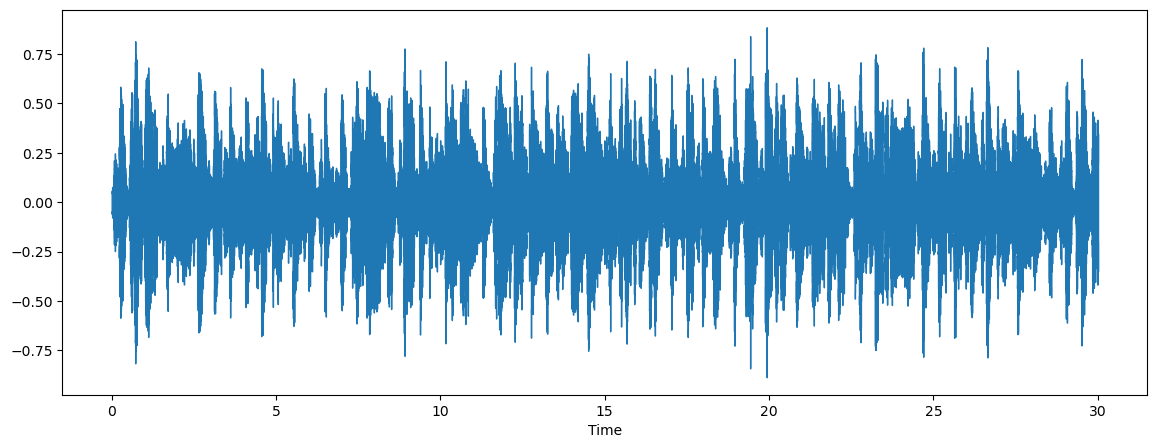

In [45]:
audio_sample_path = f'{FOLDER}/blues/blues.00000.au'
x, sr = load_audio(audio_sample_path)
# Вывод сигнала на экран
plt.figure(figsize=(14, 5))               # Задание размера полотна
librosa.display.waveshow(x, sr=sr)        # Построение амплитудного представления сигнала
plt.show()                                # Вывод графика

In [26]:
# Разделение набора данных на обучающую и проверочную выборки
# Параметр stratify указывает метки классов, по которым происходит балансировка разделения
# ЗДЕСЬ ОСИ МЕНЯЮТСЯ МЕСТАМИ Т.К.ТРЕБУДЕТСЯ ИСПОЛЬЗОВАТЬ CONV1D
print(x_data.shape)
x_train, x_val, y_train, y_val = train_test_split(x_data.swapaxes(1,2) ,
                                                  y_data,
                                                  stratify=y_data,
                                                  test_size=VALIDATION_SPLIT)
# Проверка формы и типа данных обучающей и проверочной выборок
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print()
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(8000, 37, 645)
(7200, 645, 37) float64
(7200, 10) float32

(800, 645, 37) float64
(800, 10) float32


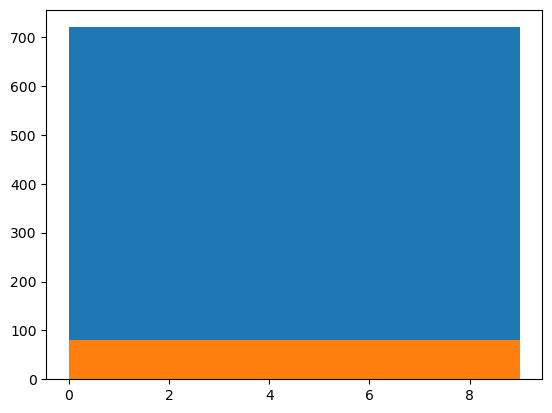

In [20]:
# Проверка сбалансированности выборок по классам
plt.hist(np.argmax(y_train, axis=1), CLASS_COUNT)
plt.hist(np.argmax(y_val, axis=1), CLASS_COUNT)
plt.show()

# Dataset_2.1 processing 1. Задача определения эмоций

## Girerparams

In [122]:
FOLDER = 'audio_emotions'
FILE_DIR = FOLDER
download_path = 'https://storage.yandexcloud.net/aiueducation/Content/base/l12/dataverse_files.zip'
CLASS_LIST = os.listdir(FOLDER)
CLASS_LIST = list(set([x.split('_')[2].split('.')[0] for x in CLASS_LIST if '.wav' in x]))
CLASS_LIST.sort()                         # Сортировка списка классов для фиксации порядка меток
CLASS_COUNT = len(CLASS_LIST)

VALIDATION_SPLIT = 0.1                    # Доля проверочной выборки в основном наборе
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков
CLASS_LIST

['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']

## Service functions

In [126]:
def extract_data(folder_path = FOLDER,
                 duration_sec=DURATION_SEC,  # длительность аудио в секундах
                 feature_length_sec= FEATURE_LENGTH_SEC,
                 feature_hop_length_sec = FEATURE_HOP_LENGTH_SEC
                 ):

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    list_of_audio_files_paths = [] # создаем список с путями аудио_файлов (не обязательный параметр)
    audio_files_paths = [os.path.join(FOLDER, x) for x in os.listdir(FOLDER) if '.wav' in x]
    durations_list = [librosa.get_duration(filename=x) for x in audio_files_paths]
    # plt.hist(durations_list)
    # plt.show()
    FEATURE_LENGTH_SEC = max(durations_list) # в задаче будем исходить из длинны самой малой записи
    # FEATURE_HOP_LENGTH_SEC = round(FEATURE_LENGTH_SEC/5, 1)

    # print(max(durations_list), min(durations_list))
    for path in audio_files_paths: # цикл по жанрам
        audio, sr = librosa.load(path, mono = True) # load audio 30 sec
        a_data_len = audio.shape[0]

        a_sample = np.zeros(int(FEATURE_LENGTH_SEC*sr+1))
        a_sample[:a_data_len] = audio[:]

        #     features = None
        chroma_stft = librosa.feature.chroma_stft(y = a_sample, sr = sr, n_fft = N_FFT, hop_length=HOP_LENGTH)
        # Мел-кепстральные коэффициенты
        mfcc = librosa.feature.mfcc(y = a_sample, sr = sr, n_fft = N_FFT, hop_length=HOP_LENGTH)
        # Среднеквадратическая амплитуда
        rmse = librosa.feature.rms(y = a_sample, hop_length=HOP_LENGTH)
        # Спектральный центроид
        spec_cent = librosa.feature.spectral_centroid(y = a_sample, sr = sr, n_fft = N_FFT, hop_length=HOP_LENGTH)
        # Ширина полосы частот
        spec_bw = librosa.feature.spectral_bandwidth(y = a_sample, sr = sr, n_fft = N_FFT, hop_length=HOP_LENGTH)
        # Спектральный спад частоты
        rolloff = librosa.feature.spectral_rolloff(y = a_sample, sr = sr, n_fft = N_FFT, hop_length=HOP_LENGTH)
        # Пересечения нуля
        zcr = librosa.feature.zero_crossing_rate(a_sample, HOP_LENGTH)

        # добавление записи в один np.array
        features_array = np.vstack([chroma_stft, mfcc, rmse, spec_cent, spec_bw, rolloff, zcr]) # объединяем все
        features_array = np.expand_dims(features_array, axis = 0) # добавляем ось для разделения записей
        #
        #     ### Обработка аудио, дробление файла на несколько частей согласно длительности записи (a_sample_length) и шага (a_hop) (это из ДЗ)
        #     a_hop = features_array.shape[2]//duration_sec*FEATURE_HOP_LENGTH_SEC # кол-во индексов пропуска
        #     a_sample_length = features_array.shape[2]//duration_sec*FEATURE_LENGTH_SEC # размер семпла
        #     for i in range(0, features_array.shape[2]-a_sample_length, a_hop):
        #         start_index = i
        #         end_index = i+a_sample_length
        #         features = features_array[:,:,start_index:end_index
        #
        #         try:
        if x_data is None:
            x_data = features_array
        else:
            x_data = np.vstack([x_data, features_array])
        ### y_data processing start
        y = path.split('_')[-1].split('.')[0]
        class_index = CLASS_LIST.index(y)
        y_label = to_categorical(class_index, CLASS_COUNT)
        if y_data is None:
            y_data = np.array(y_label)
        else:
            y_data = np.vstack([y_data, y_label])
        print(path, x_data.shape, y_data.shape)
    print(f'Operation_time = {round(time.time() - curr_time)}')

    return x_data, y_data

## Import and visualizate data

Типы данных x и sr: <class 'numpy.ndarray'>, <class 'int'>
Форма данных x: (50119,), sr = 22050
Продолжительность сигнала: 2 с.



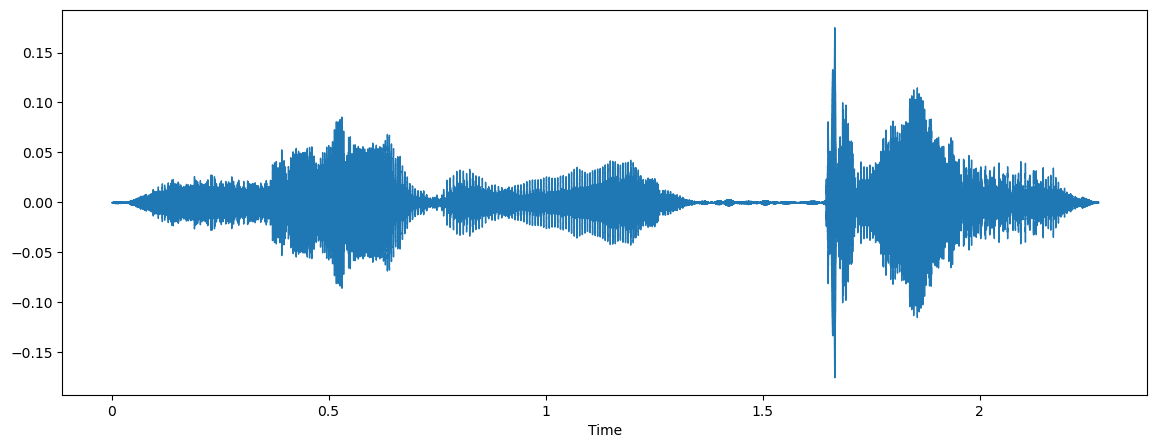

In [101]:
audio_sample_path = f'{FOLDER}/OAF_bar_disgust.wav'
x, sr = load_audio(audio_sample_path)
# Вывод сигнала на экран
plt.figure(figsize=(14, 5))               # Задание размера полотна
librosa.display.waveshow(x, sr=sr)        # Построение амплитудного представления сигнала
plt.show()                                # Вывод графика

In [100]:
x_data, y_data = extract_data()

with open(os.path.join(FOLDER, 'data_emotions.pickle'), 'wb') as f:
    pickle.dump((x_data, y_data), f)
x_data.shape, y_data.shape

# Восстановление датасета аудио
# Данные привязаны к порядку следования меток классов!
# Порядок классов фиксирован сортировкой списка меток классов
# with open(os.path.join(FOLDER, 'data_emotions.pickle'), 'rb') as f:
#     x_data, y_data = pickle.load(f)
# len([os.path.join(FOLDER, x) for x in os.listdir(FOLDER) if '.wav' in x])

((2800, 37, 129), (2800, 7))

In [106]:
# Разделение набора данных на обучающую и проверочную выборки
# Параметр stratify указывает метки классов, по которым происходит балансировка разделения
# ЗДЕСЬ ОСИ МЕНЯЮТСЯ МЕСТАМИ Т.К.ТРЕБУДЕТСЯ ИСПОЛЬЗОВАТЬ CONV1D
print(x_data.shape)
x_train, x_val, y_train, y_val = train_test_split(x_data.swapaxes(1,2) ,
                                                  y_data,
                                                  stratify=y_data,
                                                  test_size=VALIDATION_SPLIT)
# Проверка формы и типа данных обучающей и проверочной выборок
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print()
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(2800, 37, 129)
(2520, 129, 37) float64
(2520, 7) float32

(280, 129, 37) float64
(280, 7) float32


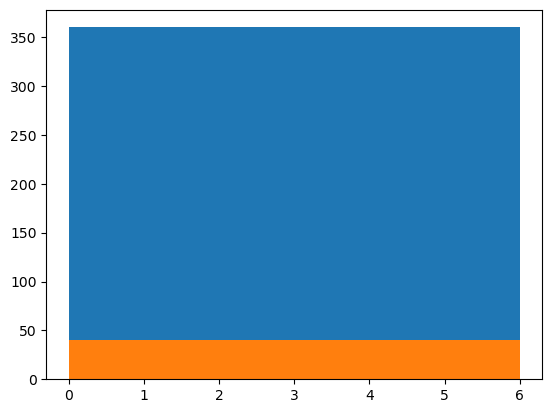

In [107]:
# Проверка сбалансированности выборок по классам
plt.hist(np.argmax(y_train, axis=1), CLASS_COUNT)
plt.hist(np.argmax(y_val, axis=1), CLASS_COUNT)
plt.show()

# Dataset_2.2 processing 1. Задача определения эмоций

## Girerparams

In [154]:
FOLDER = 'audio_emotions/ALL'
FILE_DIR = FOLDER
download_path = 'https://storage.yandexcloud.net/aiueducation/Content/base/l12/archive.zip'
CLASS_LIST = os.listdir(FOLDER)
import re
CLASS_LIST = list(set([re.sub(r'[^a-zA-Z]', '',x.split('_')[1].split('.')[0]) for x in CLASS_LIST if '.wav' in x]))

CLASS_LIST.sort()                         # Сортировка списка классов для фиксации порядка меток
CLASS_COUNT = len(CLASS_LIST)

VALIDATION_SPLIT = 0.2                   # Доля проверочной выборки в основном наборе
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков
CLASS_LIST

['a', 'd', 'f', 'h', 'n', 'sa', 'su']

## Service functions

In [164]:
def extract_data(folder_path = FOLDER,
                 duration_sec=DURATION_SEC,  # длительность аудио в секундах
                 feature_length_sec= FEATURE_LENGTH_SEC,
                 feature_hop_length_sec = FEATURE_HOP_LENGTH_SEC
                 ):

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    list_of_audio_files_paths = [] # создаем список с путями аудио_файлов (не обязательный параметр)
    audio_files_paths = [os.path.join(FOLDER, x) for x in os.listdir(FOLDER) if '.wav' in x]
    durations_list = [librosa.get_duration(filename=x) for x in audio_files_paths]
    plt.hist(durations_list)
    plt.show()
    FEATURE_LENGTH_SEC = max(durations_list) # в задаче будем исходить из длинны самой малой записи
    # FEATURE_HOP_LENGTH_SEC = round(FEATURE_LENGTH_SEC/5, 1)

    # print(max(durations_list), min(durations_list))
    for path in audio_files_paths: # цикл по жанрам
        audio, sr = librosa.load(path, mono = True) # load audio 30 sec
        a_data_len = audio.shape[0]

        a_sample = np.zeros(int(FEATURE_LENGTH_SEC*sr+1))
        a_sample[:a_data_len] = audio[:]

        #     features = None
        chroma_stft = librosa.feature.chroma_stft(y = a_sample, sr = sr, n_fft = N_FFT, hop_length=HOP_LENGTH)
        # Мел-кепстральные коэффициенты
        mfcc = librosa.feature.mfcc(y = a_sample, sr = sr, n_fft = N_FFT, hop_length=HOP_LENGTH)
        # Среднеквадратическая амплитуда
        rmse = librosa.feature.rms(y = a_sample, hop_length=HOP_LENGTH)
        # Спектральный центроид
        spec_cent = librosa.feature.spectral_centroid(y = a_sample, sr = sr, n_fft = N_FFT, hop_length=HOP_LENGTH)
        # Ширина полосы частот
        spec_bw = librosa.feature.spectral_bandwidth(y = a_sample, sr = sr, n_fft = N_FFT, hop_length=HOP_LENGTH)
        # Спектральный спад частоты
        rolloff = librosa.feature.spectral_rolloff(y = a_sample, sr = sr, n_fft = N_FFT, hop_length=HOP_LENGTH)
        # Пересечения нуля
        zcr = librosa.feature.zero_crossing_rate(a_sample, HOP_LENGTH)

        # добавление записи в один np.array
        features_array = np.vstack([chroma_stft, mfcc, rmse, spec_cent, spec_bw, rolloff, zcr]) # объединяем все
        features_array = np.expand_dims(features_array, axis = 0) # добавляем ось для разделения записей
        #
        #     ### Обработка аудио, дробление файла на несколько частей согласно длительности записи (a_sample_length) и шага (a_hop) (это из ДЗ)
        #     a_hop = features_array.shape[2]//duration_sec*FEATURE_HOP_LENGTH_SEC # кол-во индексов пропуска
        #     a_sample_length = features_array.shape[2]//duration_sec*FEATURE_LENGTH_SEC # размер семпла
        #     for i in range(0, features_array.shape[2]-a_sample_length, a_hop):
        #         start_index = i
        #         end_index = i+a_sample_length
        #         features = features_array[:,:,start_index:end_index
        #
        #         try:
        if x_data is None:
            x_data = features_array
        else:
            x_data = np.vstack([x_data, features_array])
        ### y_data processing start

        y = re.sub(r'[^a-zA-Z]', '', path.split('_')[-1].split('.')[0])
        class_index = CLASS_LIST.index(y)
        y_label = to_categorical(class_index, CLASS_COUNT)
        if y_data is None:
            y_data = np.array(y_label)
        else:
            y_data = np.vstack([y_data, y_label])
        print(path, x_data.shape, y_data.shape)
    print(f'Operation_time = {round(time.time() - curr_time)}')

    return x_data, y_data

## Import and visualizate data

Типы данных x и sr: <class 'numpy.ndarray'>, <class 'int'>
Форма данных x: (82380,), sr = 22050
Продолжительность сигнала: 4 с.



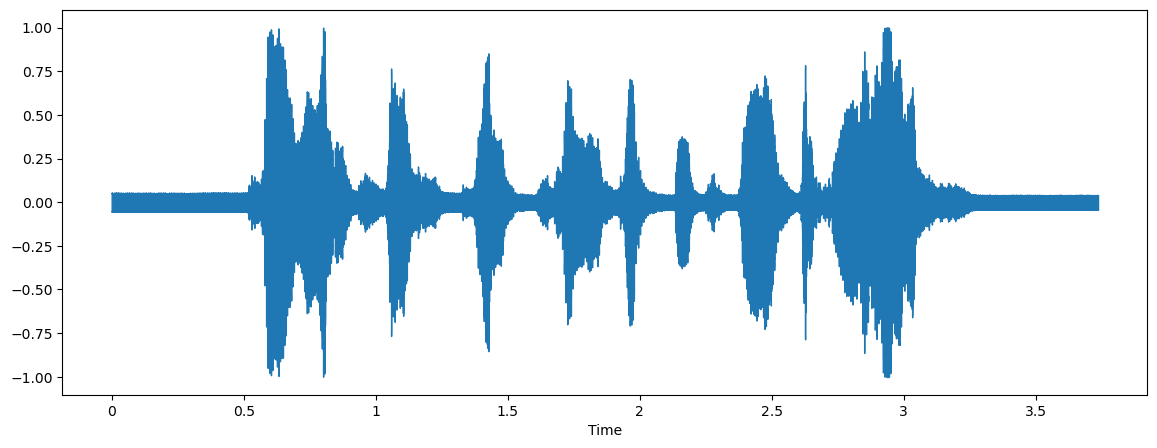

In [129]:
audio_sample_path = f'{FOLDER}/DC_a06.wav'
x, sr = load_audio(audio_sample_path)
# Вывод сигнала на экран
plt.figure(figsize=(14, 5))               # Задание размера полотна
librosa.display.waveshow(x, sr=sr)        # Построение амплитудного представления сигнала
plt.show()                                # Вывод графика

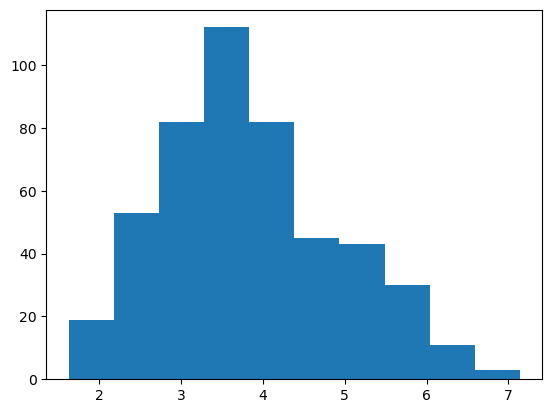

C:\Users\user\AppData\Local\Temp\ipykernel_1752\3648172157.py:43: FutureWarning: Pass frame_length=512 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  zcr = librosa.feature.zero_crossing_rate(a_sample, HOP_LENGTH)


audio_emotions/ALL\DC_a01.wav (1, 37, 308) (7,)
audio_emotions/ALL\DC_a02.wav (2, 37, 308) (2, 7)
audio_emotions/ALL\DC_a03.wav (3, 37, 308) (3, 7)
audio_emotions/ALL\DC_a04.wav (4, 37, 308) (4, 7)
audio_emotions/ALL\DC_a05.wav (5, 37, 308) (5, 7)
audio_emotions/ALL\DC_a06.wav (6, 37, 308) (6, 7)
audio_emotions/ALL\DC_a07.wav (7, 37, 308) (7, 7)
audio_emotions/ALL\DC_a08.wav (8, 37, 308) (8, 7)
audio_emotions/ALL\DC_a09.wav (9, 37, 308) (9, 7)
audio_emotions/ALL\DC_a10.wav (10, 37, 308) (10, 7)
audio_emotions/ALL\DC_a11.wav (11, 37, 308) (11, 7)
audio_emotions/ALL\DC_a12.wav (12, 37, 308) (12, 7)
audio_emotions/ALL\DC_a13.wav (13, 37, 308) (13, 7)


KeyboardInterrupt: 

In [165]:
x_data, y_data = extract_data()

with open(os.path.join(FOLDER, 'data_emotions.pickle'), 'wb') as f:
    pickle.dump((x_data, y_data), f)
x_data.shape, y_data.shape

# Восстановление датасета аудио
# Данные привязаны к порядку следования меток классов!
# Порядок классов фиксирован сортировкой списка меток классов
# with open(os.path.join(FOLDER, 'data_emotions.pickle'), 'rb') as f:
#     x_data, y_data = pickle.load(f)
# len([os.path.join(FOLDER, x) for x in os.listdir(FOLDER) if '.wav' in x])

In [155]:
# Разделение набора данных на обучающую и проверочную выборки
# Параметр stratify указывает метки классов, по которым происходит балансировка разделения
# ЗДЕСЬ ОСИ МЕНЯЮТСЯ МЕСТАМИ Т.К.ТРЕБУДЕТСЯ ИСПОЛЬЗОВАТЬ CONV1D
print(x_data.shape)
x_train, x_val, y_train, y_val = train_test_split(x_data.swapaxes(1,2),
                                                  y_data,
                                                  # stratify=y_data,
                                                  test_size=VALIDATION_SPLIT)
# Проверка формы и типа данных обучающей и проверочной выборок
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print()
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(480, 37, 308)
(384, 308, 37) float64
(384, 7) float32

(96, 308, 37) float64
(96, 7) float32


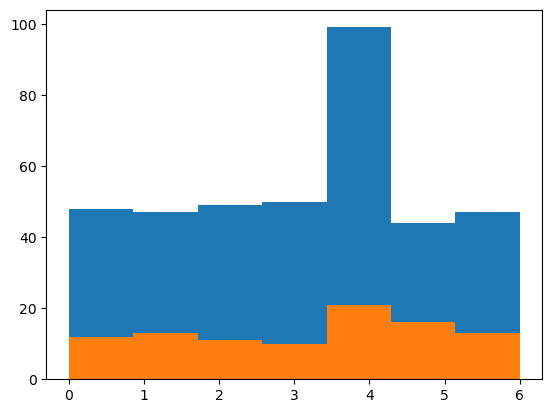

In [156]:
# Проверка сбалансированности выборок по классам
plt.hist(np.argmax(y_train, axis=1), CLASS_COUNT)
plt.hist(np.argmax(y_val, axis=1), CLASS_COUNT)
plt.show()

# Model_1. Simple CONV1d + DENCE

## Build and fit

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_33 (Bat  (None, 308, 37)          148       
 chNormalization)                                                
                                                                 
 conv1d_27 (Conv1D)          (None, 306, 64)           7168      
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 153, 64)          0         
 g1D)                                                            
                                                                 
 batch_normalization_34 (Bat  (None, 153, 64)          256       
 chNormalization)                                                
                                                                 
 conv1d_28 (Conv1D)          (None, 151, 128)          24704     
                                                     

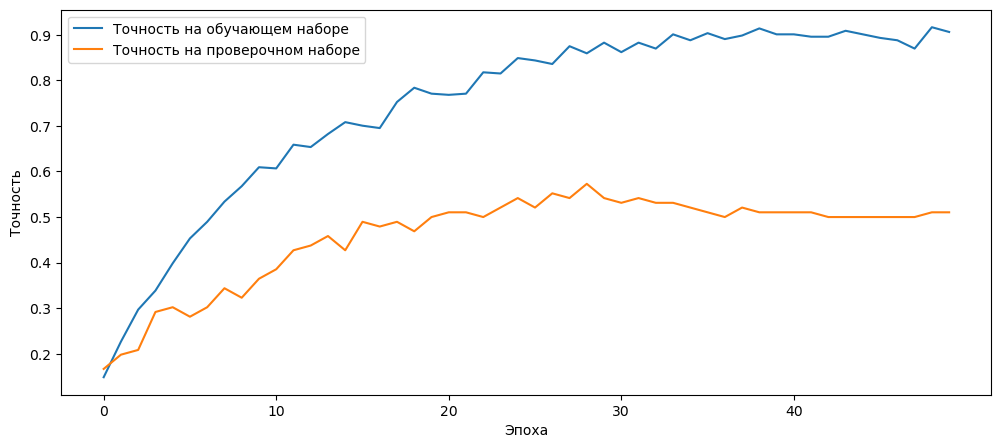

In [166]:
fitfrom tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Функция сборки и обучения классификатора на полносвязных слоях
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_accuracy', 
                                      mode = 'max',
                                      factor=0.1, 
                                      patience=5,
                                      verbose=1,
                                      min_lr=0.00001)


def create_train_classifier(in_shape,      # форма входных данных модели
                            epochs=50,    # количество эпох обучения
                            batch_size=20  # размер батча
                            ):
    model = Sequential()

    # Входной слой
    model.add(Input(shape=x_train.shape[1:]))

    # Первый сверточный блок
    model.add(BatchNormalization())
    model.add(Conv1D(64, (3,), activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Conv1D(128, (3,), activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Conv1D(256, (3,), activation='relu'))
    model.add(MaxPooling1D(2))

    model.add(Dropout(0.4))


# # Второй сверточный блок
    # model.add(BatchNormalization())
    # model.add(Conv1D(512, (3,), activation='relu'))
    # model.add(Conv1D(512, (3,), activation='relu'))
    # model.add(MaxPooling1D(3))
    #
    # # Третий сверточный блок
    # model.add(BatchNormalization())
    # model.add(Conv1D(1024, (2,), activation='relu'))
    # model.add(Conv1D(1024, (2,), activation='relu'))
    # model.add(MaxPooling1D(2))

    # Полносвязный блок
    model.add(Flatten())
    model.add(BatchNormalization())
    # model.add(Dense(512, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))

    # Финальный слой классификации
    model.add(Dense(CLASS_COUNT, activation='softmax'))
    
#     model = Model(inp, x)


    # Компиляция модели
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # Обучение модели
    history = model.fit(x_train,
                        y_train,
                        callbacks=[reduceLROnPlateau],
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графика точности распознавания на обучающей и проверочной выборках
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
    plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    plt.xticks(range(0, epochs, 10))
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()

    return model

model = create_train_classifier(x_train.shape[1:], epochs=50)

## Vusializate predictions

9/9 [==============================] - 0s 12ms/step - loss: 0.0011 - accuracy: 1.0000
Ошибка: 0.0010916546452790499, точность: 1.0
9/9 [==============================] - 0s 9ms/step


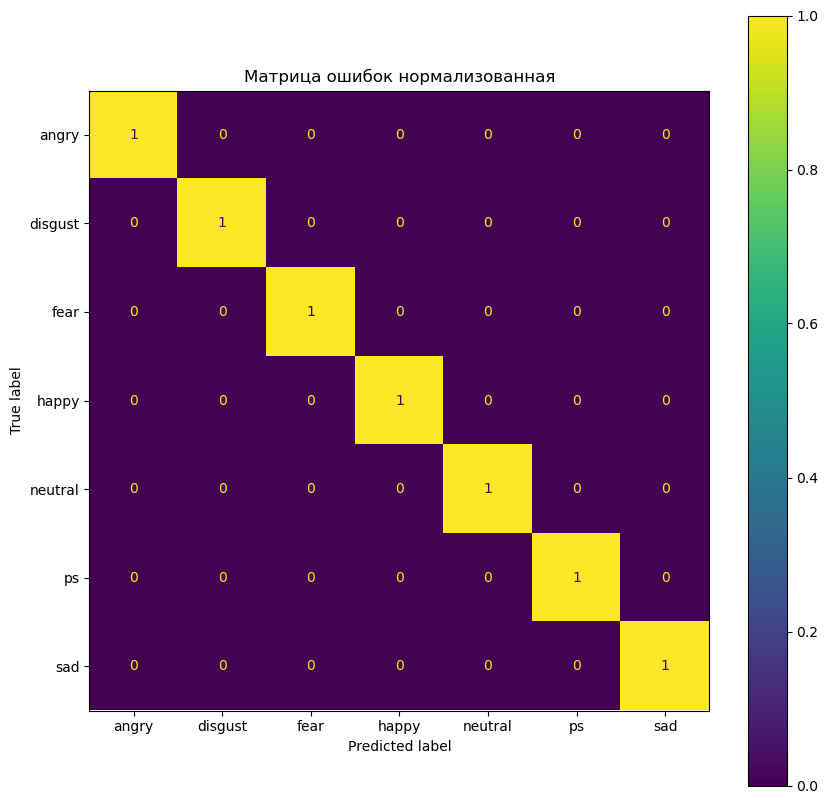

In [109]:
# Оценка точности сети на проверочной выборке
eval_model(model, x_val, y_val)